In [1]:
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
# #needed for running on laptop~~~~~
# from vedo import settings
# settings.default_backend = 'vtk'
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
# import tensorflow as tf
from scipy.spatial.transform import Rotation as R

import numpy as np
from matplotlib import pyplot as p


# Draw frames from odometry constraints

In [2]:
# print(sr_raw[:10,:3])
# print(odom_raw[:10,:3])

In [69]:
#load relative poses from odometry file
constraints = np.loadtxt("pose_data.csv", delimiter=',',skiprows=1)
# print(constraints[:,0] == 1)
# print(constraints[:,:3])

odom_raw = constraints[constraints[:,0] == 0][:,1:]  # raw odometry constraints 
sr_raw = constraints[constraints[:,0] == 1][:,1:]    # sequential registration of keyframe constraints
lc_raw = constraints[constraints[:,0] == 2][:,1:]    # loop closure constraints

print(len(odom_raw))
# print(sr_raw[:10,:3])
# odom_raw = sr_raw #DEBUG-- uncomment to draw SR traj ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#convert to rotation matrix
odom = np.zeros([len(odom_raw),4,4])
odom[0] = np.eye(4)
# odom[:,:3,-1] = odom_raw[:,2:5]  #had this pre-2/11
for i in range(1,len(odom_raw)):
    odom[i] = np.eye(4)
    curr = np.eye(4)
    curr[:3,:3] = R.from_quat(odom_raw[i,5:]).as_dcm()
    curr[:3,-1] = odom_raw[i,2:5]
    #forward conga line (works)
    for j in range(i):
        odom[j] = curr @ odom[j]    

#bring back to map frame
OG = odom[0].copy()
for j in range(len(odom_raw)):
    odom[j] = np.linalg.pinv(OG) @ odom[j]
        
sr = np.zeros([len(sr_raw),4,4])
sr[0] = np.eye(4)
for i in range(1,len(sr_raw)):
    sr[i] = np.eye(4)
    curr = np.eye(4)
    curr[:3,:3] = R.from_quat(sr_raw[i,5:]).as_dcm()
    curr[:3,-1] = sr_raw[i,2:5]
    for j in range(i):
        sr[j] = curr @ sr[j]

99


In [70]:
plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]         
scale = 0.25
runlen = len(odom) - 1
# runlen = 75

for i in range(0,runlen):
    rotm = odom[i,:,:]
#     rotm = sr[i,:,:] #TEST
#     print(rotm)
    alph = 1-(i/runlen)
    
    #forward view direction (-z in NeRF c2w convention)
    # x
    headings = rotm[:3,:3] @ np.array([scale,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,scale,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,scale])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    #draw line between odometry
    disp.append(Line(odom[i,:3,3], odom[i+1,:3,3], c = 'gray', lw=2))
    
    #draw any potential loop closure constraints
    for j in range(len(lc_raw)):
        if lc_raw[j,0] == i:
            disp.append(Line(odom[i,:3,3], odom[int(lc_raw[j,1]),:3,3], c = 'red', lw=3, alpha = 0.3))
    

plt.show(disp, "dead reckoning from odometry constraints")

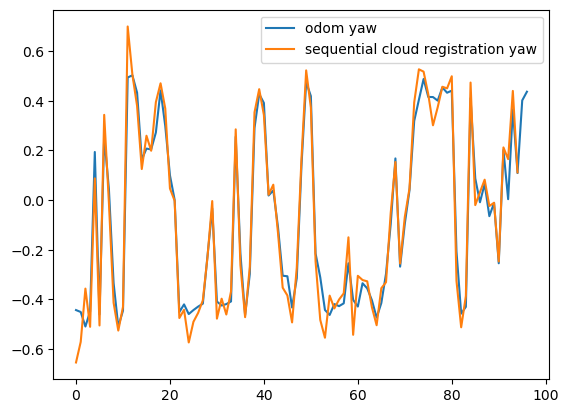

In [71]:
fig, ax = p.subplots()   
odom_euls = np.zeros([0,3])
for i in range(1,len(odom_raw)):
    rotm = R.from_quat(odom_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    odom_euls = np.append(odom_euls, rpy[None,:], axis = 0)

sr_euls = np.zeros([0,3])
for i in range(1,len(sr_raw)):
    rotm = R.from_quat(sr_raw[i,5:]).as_dcm()
    rpy = np.array([np.arctan2(rotm[2,1],rotm[2,2]), np.arcsin(rotm[2,0]), np.arctan2(rotm[1,0], rotm[0,0])])
    sr_euls = np.append(sr_euls, rpy[None,:], axis = 0)

ax.plot(odom_euls[1:,2], label = 'odom yaw')
ax.plot(sr_euls[:,2], label = 'sequential cloud registration yaw')
ax.legend(loc='best')

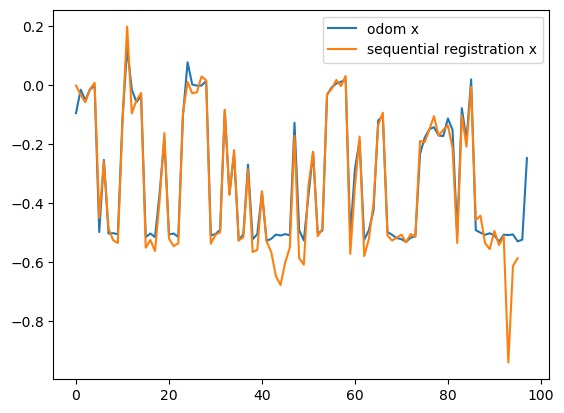

In [72]:
fig, ax = p.subplots()
# print(odom_raw[:10,2:5], "\n \n", sr_raw[:10,2:5])
ax.plot(odom_raw[1:,2], label = 'odom x')
ax.plot(sr_raw[:,2], label = 'sequential registration x')
ax.legend(loc='best')

# Draw point clouds registered according to raw odometry and sequential keyframe registration

In [73]:
#load keyframe point clouds
idx = 20
fn1 = "keyframe_" + str(idx) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
idx2 = idx + 1
fn2 = "keyframe_" + str(idx2) + ".csv"
pc2 = np.loadtxt(fn2, delimiter=",")
# print(odom_raw[idx,2:5], R.from_quat(odom_raw[idx,5:]).as_euler('xyz'))
print(odom_raw[idx])

#get row corresponding to correct odometry constraint
odom_idx = np.where(odom_raw[:,0] == idx)[0][0]
sr_idx = np.where(sr_raw[:,0] == idx)[0][0]
print(odom_idx, sr_idx)
# print(sr_euls[-5:])

# print(sr_raw[idx])
# print(odom_raw[idx])

[ 2.00000e+01  2.10000e+01 -1.80935e-01  1.84291e-01 -2.23697e-02
  4.23045e-02 -5.81042e-03  2.19705e-01  9.74631e-01]
20 19


In [74]:
plt = Plotter(N = 2, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True) #axes = 4 (simple), 1(scale)
disp_odom=[]
disp_odom.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp_odom.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
disp_sr=[]
disp_sr.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp_sr.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))

p2_p1f_odom = (pc2 - odom_raw[odom_idx,2:5]) @ R.from_quat(odom_raw[odom_idx,5:]).as_dcm()#works for odom output
p2_p1f_sr = (pc2 - sr_raw[sr_idx,2:5]) @ R.from_quat(sr_raw[sr_idx,5:]).as_dcm()#works for odom output
disp_odom.append(Points(p2_p1f_odom, c = 'green', r = 3, alpha = 0.5))
disp_sr.append(Points(p2_p1f_sr, c = 'green', r = 3, alpha = 0.5))

plt.at(0).add(disp_odom, "odometry")              
plt.at(1).add(disp_sr, "loop closure between neighboring keyframes")              
plt.show()#"scan 1 (red), scan2 (blue), scan2 in s1 frame (green)" 

[vedo.plotter.py:909] WARNING: call to add() but Plotter was not initialized with show()
[vedo.plotter.py:909] WARNING: call to add() but Plotter was not initialized with show()


# Look at loop closure canidates (from scan context)

In [75]:
print(lc_raw[:,:2])

[[31. 20.]
 [32. 18.]
 [33. 18.]
 [35. 21.]
 [37. 15.]
 [38. 15.]
 [41.  7.]
 [61. 51.]
 [62. 50.]
 [64. 48.]
 [83. 72.]
 [84. 72.]
 [86. 71.]
 [87. 71.]
 [88. 70.]
 [89. 69.]
 [90. 68.]
 [91. 65.]
 [92. 65.]
 [93. 46.]
 [97.  5.]
 [98.  1.]]


In [84]:
lc_idx = -2
print(lc_raw[lc_idx,:])
idx = int((lc_raw[lc_idx,0]))
idx2 = int((lc_raw[lc_idx,1]))
print(idx, idx2)

fn1 = "keyframe_" + str(idx) + ".csv"
pc1 = np.loadtxt(fn1, delimiter=",")
fn2 = "keyframe_" + str(idx2) + ".csv"
pc2 = np.loadtxt(fn2, delimiter=",")

plt = Plotter(N = 1, axes = 0, bg = (0.2, 0.2, 0.2), interactive = True)
disp = []
p2_p1f_lc = (pc2 - lc_raw[lc_idx,2:5]) @ R.from_quat(lc_raw[lc_idx,5:]).as_dcm()
disp.append(Points(p2_p1f_lc, c = 'green', r = 3, alpha = 0.5))

disp.append(Points(pc1, c = 'red', r = 3, alpha = 0.5))
disp.append(Points(pc2, c = 'blue', r = 3, alpha = 0.5))
plt.show(disp, "registering point clouds with scan context loop closure ") 

[ 9.70000e+01  5.00000e+00 -4.80291e-01  6.55767e-01 -4.20756e-02
 -2.25221e-02 -1.82583e-02 -3.25811e-01  9.44990e-01]
97 5


# DEBUG: Use (python) ICET to register keyframes

In [ ]:
from ICET_spherical import ICET
from utils import R_tf
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import tensorflow as tf
%load_ext autoreload

In [ ]:
fidelity = 50                                           # number of azimuthal bins to make square cross-section voxels 
num_iterations = 5                                      # number of iterations to run algorithm
is_draw = True                                          # visualize simulation
initial_guess = tf.constant([0., 0., 0., 0., 0., 0.])   # initial guess for transform between clouds
is_remove_moving = True                                 # remove moving objects from the frame 
is_DNN = False                                          # suppress voxels with high perspective shift using DNN

it = ICET(cloud1 = pc1, cloud2 = pc2, fid = fidelity, niter = num_iterations, 
           draw = is_draw, RM = is_remove_moving, DNN_filter = is_DNN, x0 = initial_guess)
# ViewInteractiveWidget(it.plt.window) #comment out if <is_daraw == False>

In [ ]:
0.5*(0.625**5)